In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
filename = r"C:\Users\田东亚\Desktop\kaggle\kobe\data.csv\data.csv"

#load_data
with open(filename) as f:
    raw = pd.read_csv(f)
raw.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
#提取训练集
nona = raw[pd.notnull(raw['shot_made_flag'])]
#print(nona)

根据loc_x 和loc_y 以及lon和lat进行对3万投篮的画图

Text(0.5, 1.0, 'lon and lat')

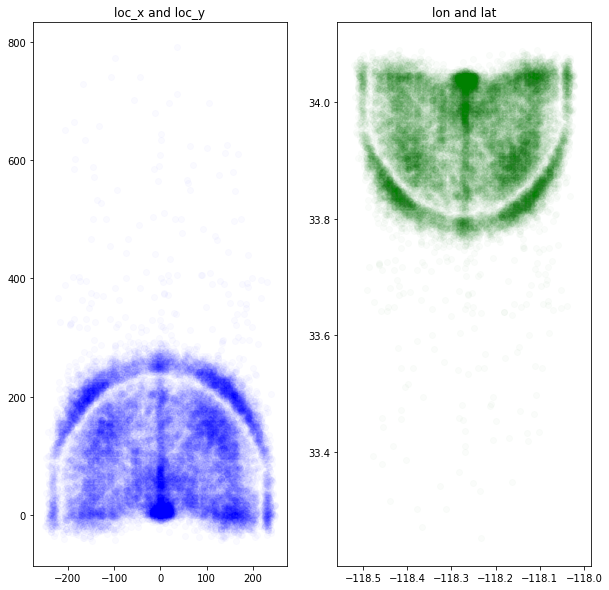

In [5]:
plt.figure(figsize = (10,10))

#loc_x and loc_y
plt.subplot(121)
plt.scatter(nona.loc_x, nona.loc_y, color = 'blue', alpha = 0.02)
plt.title('loc_x and loc_y')

#lon and lat
plt.subplot(122)
plt.scatter(nona.lon, nona.lat, color = 'green', alpha = 0.02)
plt.title('lon and lat')

In [6]:
#重构投篮距离
raw['dist'] = np.sqrt(raw['loc_x']**2 + raw['loc_y']**2)
loc_x_zero = raw['loc_x'] == 0
raw['angle'] = np.array([0]*len(raw))
raw['angle'][~loc_x_zero] = np.arctan(raw['loc_y'][~loc_x_zero] / raw['loc_x'][~loc_x_zero])
raw['angle'][loc_x_zero] = np.pi / 2 

c:\users\田东亚\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\田东亚\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


把remianing_minutes和remaining_seconds合在一起组成新的数据remaining_time

In [7]:
raw['remaining_time'] = raw['minutes_remaining']*60 + raw['seconds_remaining']

投篮动作

In [8]:
print(nona.action_type.unique())
print(nona.combined_shot_type.unique())
print(nona.shot_type.unique())

['Jump Shot' 'Driving Dunk Shot' 'Layup Shot' 'Running Jump Shot'
 'Reverse Dunk Shot' 'Slam Dunk Shot' 'Driving Layup Shot'
 'Turnaround Jump Shot' 'Reverse Layup Shot' 'Tip Shot'
 'Running Hook Shot' 'Alley Oop Dunk Shot' 'Dunk Shot'
 'Alley Oop Layup shot' 'Running Dunk Shot' 'Driving Finger Roll Shot'
 'Running Layup Shot' 'Finger Roll Shot' 'Fadeaway Jump Shot'
 'Follow Up Dunk Shot' 'Hook Shot' 'Turnaround Hook Shot' 'Jump Hook Shot'
 'Running Finger Roll Shot' 'Jump Bank Shot' 'Turnaround Finger Roll Shot'
 'Hook Bank Shot' 'Driving Hook Shot' 'Running Tip Shot'
 'Running Reverse Layup Shot' 'Driving Finger Roll Layup Shot'
 'Fadeaway Bank shot' 'Pullup Jump shot' 'Finger Roll Layup Shot'
 'Turnaround Fadeaway shot' 'Driving Reverse Layup Shot'
 'Driving Slam Dunk Shot' 'Step Back Jump shot' 'Turnaround Bank shot'
 'Reverse Slam Dunk Shot' 'Floating Jump shot' 'Putback Slam Dunk Shot'
 'Running Bank shot' 'Driving Bank shot' 'Driving Jump shot'
 'Putback Layup Shot' 'Putback Dun

赛季属性，重构赛季属性，方便数据操作

In [9]:
nona['season'].unique()

array(['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '1996-97', '1997-98',
       '1998-99', '1999-00'], dtype=object)

In [10]:
raw['season'] = raw['season'].apply(lambda x: int(x.split('-')[1]) )
raw['season'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 97,
       98, 99,  0], dtype=int64)

球队ID和球队名字

In [11]:
print(nona['team_id'].unique())
print(nona['team_name'].unique())

[1610612747]
['Los Angeles Lakers']


matchup属性和opponent属性

In [12]:
print(nona['matchup'].unique())
print(nona['opponent'].unique())

['LAL @ POR' 'LAL vs. UTA' 'LAL @ VAN' 'LAL vs. LAC' 'LAL @ HOU'
 'LAL @ SAS' 'LAL vs. HOU' 'LAL vs. DEN' 'LAL @ SAC' 'LAL @ DEN'
 'LAL vs. CHI' 'LAL vs. GSW' 'LAL vs. MIN' 'LAL @ LAC' 'LAL vs. IND'
 'LAL @ SEA' 'LAL vs. SAS' 'LAL vs. DAL' 'LAL vs. PHI' 'LAL @ GSW'
 'LAL vs. SEA' 'LAL vs. DET' 'LAL vs. MIL' 'LAL vs. VAN' 'LAL @ TOR'
 'LAL @ MIA' 'LAL @ DAL' 'LAL vs. POR' 'LAL @ PHX' 'LAL vs. CLE'
 'LAL @ UTA' 'LAL vs. MIA' 'LAL vs. NJN' 'LAL @ NYK' 'LAL @ CLE'
 'LAL @ MIN' 'LAL vs. CHH' 'LAL vs. SAC' 'LAL vs. PHX' 'LAL @ NJN'
 'LAL @ PHI' 'LAL @ CHH' 'LAL @ IND' 'LAL vs. TOR' 'LAL @ DET' 'LAL @ WAS'
 'LAL @ ORL' 'LAL @ ATL' 'LAL @ MIL' 'LAL vs. NYK' 'LAL vs. MEM'
 'LAL vs. ORL' 'LAL @ MEM' 'LAL @ CHI' 'LAL vs. WAS' 'LAL vs. ATL'
 'LAL vs. BOS' 'LAL @ BOS' 'LAL vs. NOH' 'LAL @ NOH' 'LAL @ UTH'
 'LAL vs. SAN' 'LAL @ NOK' 'LAL @ PHO' 'LAL vs. NOK' 'LAL vs. PHO'
 'LAL @ CHA' 'LAL vs. CHA' 'LAL vs. OKC' 'LAL @ OKC' 'LAL vs. BKN'
 'LAL @ BKN' 'LAL @ NOP' 'LAL vs. NOP']
['POR' 'UTA' 'VAN' 'LA

shot_distance属性和我们自己构建出来的dist属性

In [13]:
print(raw['dist'].head())
print(raw['dist'].max())
print(raw['shot_distance'].head())
print(raw['shot_distance'].max())

0    181.859836
1    157.000000
2    168.600119
3    222.865430
4      0.000000
Name: dist, dtype: float64
791.8187924013928
0    18
1    15
2    16
3    22
4     0
Name: shot_distance, dtype: int64
79


Text(0.5, 1.0, 'dist and shot_distance')

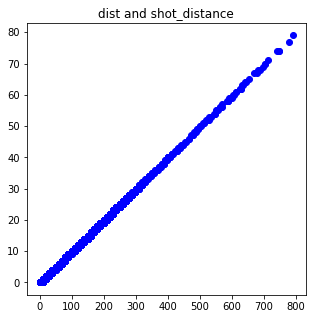

In [14]:
plt.figure(figsize=(5,5))
plt.scatter(raw.dist, raw.shot_distance, color='blue')
plt.title('dist and shot_distance')

shot_zone_area属性shot_zone_basic属性shot_zone_range属性查看

Text(0.5, 1.0, 'shot_zone_range')

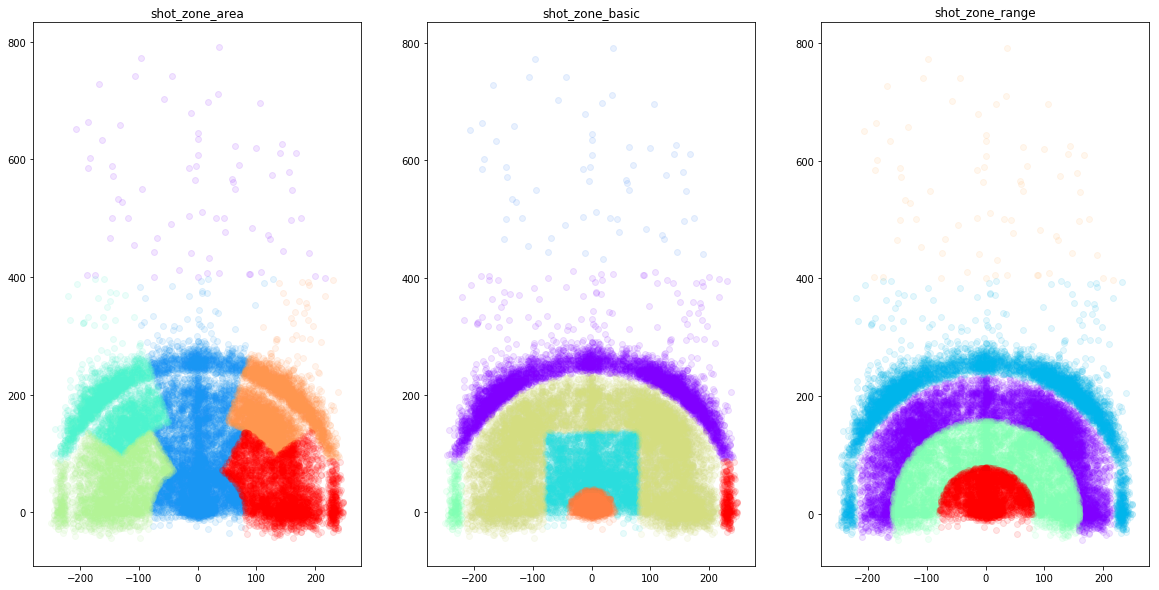

In [15]:
plt.figure(figsize=(20,10))

def scatter_plot(feat):
    alpha = 0.1
    gs = nona.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

# shot_zone_area
plt.subplot(131)
scatter_plot('shot_zone_area')
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)
scatter_plot('shot_zone_basic')
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)
scatter_plot('shot_zone_range')
plt.title('shot_zone_range')

In [16]:
raw['dist'] = np.sqrt(raw['loc_x']**2 + raw['loc_y']**2)

#特征选择，去掉不用的数据，从上面的分析来看：shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic','matchup'（和opponent保留一个）, 'lon', 'lat'(精度和纬度，和loc_x,loc_y效果相同，取后者), 'seconds_remaining', 'minutes_remaining'(这个我们已经将两个重构成一个remainint_time),'shot_distance'（和dist是线性关系，保留dist）, 'loc_x', 'loc_y'（loc_x,loc_y两个属性已经重构成dist，不在取用）, 'game_event_id', 'game_id', 'game_date'

In [17]:
drops = ['shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic', 'matchup', 'lon', 'lat', \
         'seconds_remaining', 'minutes_remaining', 'shot_distance', 'loc_x', 'loc_y', 'game_event_id', 'game_id', 'game_date']

for drop_feat in drops:
    raw = raw.drop(drop_feat,1)

将string类型的属性用虚拟变量替换

In [18]:
categorical_vars = ['action_type', 'combined_shot_type', 'shot_type', 'opponent', 'period', 'season']
for var in categorical_vars:
    raw = pd.concat([raw, pd.get_dummies(raw[var], prefix=var)], 1)
    raw = raw.drop(var, 1)

In [19]:
print(len(raw))
raw.head()

30697


,playoffs,shot_made_flag,dist,angle,remaining_time,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,action_type_Cutting Finger Roll Layup Shot,action_type_Cutting Layup Shot,action_type_Driving Bank shot,...,season_10,season_11,season_12,season_13,season_14,season_15,season_16,season_97,season_98,season_99
0,0,NaN,181.859836,0.407058,627,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.0,157.000000,-0.000000,622,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1.0,168.600119,-0.928481,465,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.0,222.865430,0.903063,412,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1.0,0.000000,1.570796,379,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


构建训练数据和测试数据

In [20]:
df = raw[pd.notnull(raw['shot_made_flag'])]
submission = raw[pd.isnull(raw['shot_made_flag'])]
print(len(submission))
submission = submission.drop('shot_made_flag', 1)
train = df.drop('shot_made_flag', 1)
print(len(train))
train_y = df['shot_made_flag']
print(len(train_y))

5000
25697
25697


### 构建模型

##### 损失函数

In [21]:
def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    loss = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    loss = loss * -1.0/len(act)
    return loss

In [22]:
rang = np.logspace(0,2,num = 3).astype(int)
score = []
best_n = 0
min_score = 1000

for n in rang:
    print("the num of trees:{0}".format(n))
    modle = RandomForestClassifier(n_estimators=n)
    modle_score = 0
    
    for train_k, test_k in KFold(n_splits=10,shuffle= True).split(train):
        modle.fit(train.iloc[train_k], train_y.iloc[train_k])
        pred = modle.predict(train.iloc[test_k])
        modle_score += logloss(train_y.iloc[test_k], pred) / 10
    score.append(modle_score)
    if modle_score < min_score:
        min_score = modle_score
        best_n = n
    print("n:{0}  score:{1}".format(n,modle_score))
print("best n_estimators: {0}".format(best_n))

the num of trees:1
n:1  score:14.365658134303244
the num of trees:10
n:10  score:12.372342541118229
the num of trees:100
n:100  score:11.883070086827095
best n_estimators: 100


In [24]:
rang = np.logspace(0,2,num = 3).astype(int)
score = []
best_depth = 0
min_score = 1000

for n in rang:
    print("the num of trees:{0}".format(n))
    modle = RandomForestClassifier(max_depth = n)
    modle_score = 0
    
    for train_k, test_k in KFold(n_splits=10,shuffle= True).split(train):
        modle.fit(train.iloc[train_k], train_y.iloc[train_k])
        pred = modle.predict(train.iloc[test_k])
        modle_score += logloss(train_y.iloc[test_k], pred) / 10
    score.append(modle_score)
    if modle_score < min_score:
        min_score = modle_score
        best_depth = n
    print("n:{0}  score:{1}".format(n,modle_score))
print("best depth: {0}".format(best_depth))

the num of trees:1


c:\users\田东亚\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


n:1  score:13.619596980025499
the num of trees:10


c:\users\田东亚\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


n:10  score:11.067190907335636
the num of trees:100


c:\users\田东亚\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


n:100  score:12.26079397648055
best depth: 10


In [23]:
#light GB常规参数
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.1,
    'max_depth': 3,  
    'metric':'auc',
    'min_data_in_leaf': 30,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 8,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

#### lightGBM模型

In [24]:
def lightGBM(train,train_y):
    folds = StratifiedKFold(n_splits = 5, shuffle = False, random_state = None)
    temp_pre = np.zeros(len(train))
    acu_pre = np.zeros(len(submission))

    for fold_num,(train_index,valid_index) in enumerate(folds.split(train,train_y)):
        #print(len(train))
        #print(len(train_y))
        print("Fold {}".format(fold_num))
        train_X,valid_X,train_y1,valid_y = train.iloc[train_index],train.iloc[valid_index],\
                                            train_y.iloc[train_index],train_y.iloc[valid_index]
        train_data = lgb.Dataset(train_X,label = train_y1)
        valid_data = lgb.Dataset(valid_X,label = valid_y)
        clf = lgb.train(param, train_data, num_boost_round = 1000, valid_sets = [valid_data], early_stopping_rounds = 100,verbose_eval=1000)
        temp_pre[valid_index] = clf.predict(valid_X,num_iteration = clf.best_iteration)
        #print("test")
        #print(len(valid_y))
        #print(len(temp_pre))
        acu_pre += clf.predict(submission,num_iteration = clf.best_iteration) / folds.n_splits
        print("CV score: {:<8.5f}".format(roc_auc_score(train_y, temp_pre)))
    return acu_pre

pred = lightGBM(train,train_y)

Fold 0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[776]	valid_0's auc: 0.698096
CV score: 0.50790 
Fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[877]	valid_0's auc: 0.68496
CV score: 0.53059 
Fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[189]	valid_0's auc: 0.668158
CV score: 0.56624 
Fold 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[124]	valid_0's auc: 0.668408
CV score: 0.61575 
Fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[440]	valid_0's auc: 0.689976
CV score: 0.68244 


随机森林模型

In [86]:
def train_re(clf):
    folds = StratifiedKFold(n_splits = 5, shuffle = False, random_state = None)
    temp_pre = np.zeros(len(train))
    acu_pre = np.zeros(len(submission))
    result = []
    acu_result = []
    for fold_num,(train_index,valid_index) in enumerate(folds.split(train,train_y)):
        print("Fold {}".format(fold_num))
        train_X,valid_X,train_y1,valid_y = train.iloc[train_index],train.iloc[valid_index],\
                                            train_y.iloc[train_index],train_y.iloc[valid_index]
        #clf = RandomForestClassifier(n_estimators=100, max_depth=10)
        clf.fit(train_X,train_y1)
        temp_pre = clf.predict_proba(valid_X)
        result.append(temp_pre)
        #print(valid_y.shape)
        #print(temp_pre.shape)
        #print(len(submission))
        acu_pre = clf.predict_proba(submission)
        #print(len(acu_pre))
        acu_result.append(acu_pre)
        print("CV score: {:<8.5f}".format(roc_auc_score(valid_y, temp_pre[:,1])))
    return result,acu_result

In [87]:
random_result,acu_random_result = train_re(RandomForestClassifier(n_estimators=100, max_depth=10))

Fold 0
CV score: 0.69508 
Fold 1
CV score: 0.67122 
Fold 2
CV score: 0.68327 
Fold 3
CV score: 0.66228 
Fold 4
CV score: 0.69562 


In [90]:
#时间很慢
gbt_result,acu_gbt_result = train_re(GradientBoostingClassifier(n_estimators = 100,max_depth = 10))

Fold 0
CV score: 0.67006 
Fold 1
CV score: 0.67350 
Fold 2
CV score: 0.66526 
Fold 3
CV score: 0.59990 
Fold 4
CV score: 0.68808 


In [ ]:
xgb_result,acu_xgb_result = train_re(XGBClassifier(n_estimators=100, max_depth=10))

Fold 0
CV score: 0.66514 
Fold 1


In [89]:
print(len(xgb_result[0]))
print(len(acu_random_result))

5140
5


In [76]:
model = RandomForestClassifier(n_estimators=100, max_depth=10)
model.fit(train, train_y)
pred = model.predict_proba(submission)
print(pred)

[[0.63252332 0.36747668]
 [0.61438542 0.38561458]
 [0.34913988 0.65086012]
 ...
 [0.36452214 0.63547786]
 [0.32745848 0.67254152]
 [0.51232566 0.48767434]]


In [39]:
model = XGBClassifier(n_estimators=100, max_depth=10)
model.fit(train, train_y)
pred = model.predict_proba(submission)
print(pred)

[[0.6904259  0.30957416]
 [0.6035112  0.39648876]
 [0.44014674 0.55985326]
 ...
 [0.3154196  0.6845804 ]
 [0.25193578 0.7480642 ]
 [0.263426   0.736574  ]]


极端随机树模型

In [96]:
model_one = ExtraTreesClassifier(n_estimators = 100, max_depth = 10)
model_one.fit(train,train_y)
pred_one = model_one.predict_proba(submission)
print(pred_one)

[[0.62912053 0.37087947]
 [0.63391698 0.36608302]
 [0.32163198 0.67836802]
 ...
 [0.33091424 0.66908576]
 [0.33320438 0.66679562]
 [0.51720999 0.48279001]]


梯度提升树模型

In [97]:
model_two = GradientBoostingClassifier(n_estimators = 100,max_depth = 10)
model_two.fit(train,train_y)
pred_two = model_two.predict_proba(submission)
print(pred_two)

[[0.68341712 0.31658288]
 [0.62494084 0.37505916]
 [0.48875632 0.51124368]
 ...
 [0.25536244 0.74463756]
 [0.2465714  0.7534286 ]
 [0.21033025 0.78966975]]


In [47]:
test_path = r"C:\Users\田东亚\Desktop\kaggle\kobe\sample_submission.csv\sample_submission.csv"
with open(test_path) as f:
    sub_t = pd.read_csv(f)
sub_t['shot_made_flag'] = pred
sub_t.to_csv(r"C:\Users\田东亚\Desktop\kaggle\kobe\real_submission.csv", index=False)